# ecoinvent efficiencies simulation

We want to change the "technosphere" and "biosphere" exchanges of an activity by scaling them down by a percentage (e.g. 10%) while keeping the "Production" exchange the same. This means that whila an activity originally required 10 kg of technosphere input A to produe 1 kg of production output B, then we need a function that creates a copy of this activity that only needs 9 kg of A to produce 1 kg of B. This will simulate an **improvement in efficiency** for the activity that might be due to e.g. **technology upsacling or learning** effects and is hyphotesized to be **non-linear**


## Import libraries

In [1]:
# Python libraries
# Data manipulation
import random
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2


In [2]:
#Local library
import brightway2 as bw

In [3]:
bw.projects.set_current("Massimo")
bw.databases

Databases dictionary with 0 objects

In [4]:
bw.projects.set_current('non-linearity')

In [4]:
#bw.bw2setup() # do only first time

In [5]:
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ecoinvent 3.6 conseq

In [10]:
ei36dir = "/Users/massimo/Documents/Databases/ecoinvent v3.6/datasets"

if 'ecoinvent 3.6 conseq' in bw.databases: #this time im renaming the database i'll alter with _n
    print("Database has already been imported")
else:
    ei36 = bw.SingleOutputEcospold2Importer(ei36dir, 'ecoinvent 3.6 conseq')
    ei36.apply_strategies()
    ei36.statistics()
    ei36.write_database()

Extracting XML data from 16459 datasets
Extracted 16459 datasets in 52.35 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
3 exchanges couldn't be linked and were deleted. See the logfile for details:
	/Users/massimo/Library/Logs/Brightway3/non-linearity.bff727cca2fd2c65bd9

Writing activities to SQLite3 database:


16459 datasets
467562 exchanges
0 unlinked exchanges
  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:41


Title: Writing activities to SQLite3 database:
  Started: 09/15/2020 18:28:17
  Finished: 09/15/2020 18:28:58
  Total time elapsed: 00:00:41
  CPU %: 91.00
  Memory %: 8.05
Created database: ecoinvent 3.6 conseq


# Part one
### Where we investigate the effect of progressively increasing the efficiency of the inputs of specific activities

We want to modify the efficiency of coal power plants.
We colect their codes.

In [9]:
looking_for = ["electricity", "production", "coal"]
forbidden = ["aluminium", "supercritical", "mine"]
coal_power_plants = [a.key for a in bw.Database("ecoinvent 3.6 conseq")
                     if all(x in a["name"] for x in looking_for)
                    and not any(x in a["name"] for x in forbidden)
                    and a["reference product"] == "electricity, high voltage"]

We want to examine the effect of efficiency change on a number of activities.

In [11]:
FU = [{bw.Database("ecoinvent 3.6 conseq").random():1} for a in range(10)]

In [12]:
l_res = []

# `x` will represent our efficiency increase factor.
# Here we start at 1 (meaning unmodified) and go down to .2, representing a efficiency increase of 400%, right? (1/.2)

for x in np.arange(1.0, .1, -.1):
    
    # We build a first time the technology matrix.
    
    LCA = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    
    
    # We get the row numbers of the power plants on the technology matrix
    coal_pp_col = [LCA.activity_dict[a] for a in coal_power_plants]
    
    # We select the columns that correspond to the power plants in the tech matrix
    # And we decrease all the values row-wise by increment of 0.1, except for the values
    # in the diagonal (which represent the electricity output)
    
    LCA.technosphere_matrix[
        np.ix_([c for c in range(0, LCA.technosphere_matrix.shape[0]) if c not in coal_pp_col],
               coal_pp_col)] *= x
    
    # Then we iterate through our FUs
    
    for j, fu in enumerate(FU):
        LCA.redo_lci(fu)
        LCA.lcia()
        l_res.append(((1/x-1)*100, list(fu.keys())[0]["name"], LCA.score))

In [13]:
res = pd.DataFrame(l_res, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name", "PP efficiency increase (%)"])[["GWP"]].sum()

Text(0.5, 0, 'Coal PP efficiency increase')

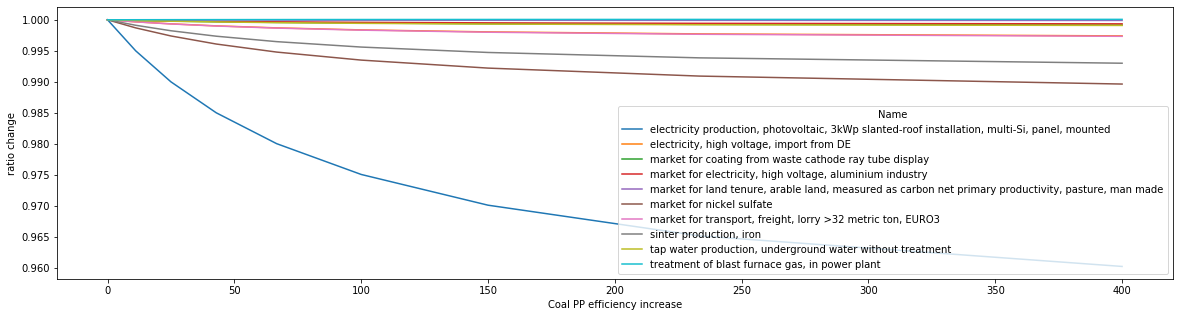

In [14]:
(res / pd.DataFrame(l_res, columns=['PP efficiency increase (%)', 'Name', 'GWP'])\
    .groupby(["Name"])[["GWP"]].first())["GWP"].unstack().T.plot(figsize=(20, 5))
plt.ylabel("ratio change")
plt.xlabel("Coal PP efficiency increase")

# Part two

### Where we study the more general effect of (randomly) increasing the efficiency of transformation activities

We look only at transformation activities, not market ones - because the transformation activities are those where you can have efficiency gains while the market ones are only a mix of transformation activities (the sum of which = 1) + transport, so not much to upscale there. So we filter the database to select only transformation activities. 

We will then select some **other** activities (market activities, ideally) and then analyze their impact (e.g. kg CO2-eq) both with the default version of the database and with the "improvement scenario" (specific inputs of the transformation activities reduced by a percentage) and then compare the difference, i.e. the **ration** between the two impact values expressed as a number between 0 and 1. The hyphothesis is that the improved version shuold have a lower impact than the default one.


In [6]:
mydb = bw.Database('ecoinvent 3.6 cutoff')

In [6]:
mydb = bw.Database('ecoinvent 3.6 conseq')

In [7]:
# Create list with all transforming activities in the database

transf_act = [act for act in mydb if 'ordinary transforming activity' in act['activity type']]

In [8]:
# Create a list of random activities to study

# Method 1, import a predefined list (for reproducibility)
mysample = pd.read_csv('sample_codes.csv')['samplecodes'].values.tolist()  # this to get it back
random_acts = [mydb.get(code) for code in mysample]

# Method 2, completely random selection
#random_acts =  [mydb.random() for act in range(50)] # very coarse

# Method 3, selecte only among specific market activities (avoid treatment ones that have negative results)
#m_act = [act for act in mydb if 
#              ('market activity' in act['activity type'] and 
#               act['production amount'] > 0)] # exclude waste markets and treatment activities
#random_acts =  random.sample(m_act,50) # 

In [9]:
# extract lists of codes, names, and FUs for future use

l_names = [act['name'] for act in random_acts]
l_codes = [act['code'] for act in random_acts]  
FU = [{act:1} for act in random_acts] 

# dump this as a list for future use
#pd.DataFrame(l_codes).to_csv('sample_codes.csv', index=False, header = ['samplecodes'], sep = ';')

In [10]:
# calculate base values for the sample activities (before improving the efficiency of the transformation ones)

l_res_base = []

for j, fu in enumerate(FU): 
    LCA = bw.LCA(fu, ('IPCC 2013', 'climate change', 'GWP 100a'))
    LCA.lci()
    LCA.lcia()
    l_res_base.append(LCA.score) 
    
pd.DataFrame({'name' : l_names, 'code' :l_codes, 'GWP' : l_res_base}).head()

name                              code  \
0          market for manganese sulfate  7f2b1a5888048ce0ff4262dafdbd7403   
1                market for boric oxide  6f88782e19197f33d99047e95eddcd74   
2  market for aluminium sulfate, powder  3cd56ed5c796df04ba7d3aaf34409672   
3        market for tower silo, plastic  e0c2c8177c816d7f54bbba57bb341680   
4                  market for imidazole  02a82d3c95a59af5abf3ee8328bed218   

          GWP  
0    0.803624  
1    2.305038  
2    0.492805  
3  140.062618  
4    5.101908

A key question is **how** to simulate potential efficiency gains.

We could do this completely randomly. One can improve an exchange input between 100% ( = no change) and 0% (no need for the input). Or in other words one can imagine that the database providers have reported an exchange that is far 0-100% from max efficiency (this is how much they could be "wrong" in terms of getting the right scale for the activity). Since **we don't know which exchanges can be improved** and where the upscaling uncertainty is, then we assume that "in general" most exchanges will be close to the max efficiency (ecoinvent database providers ask large established industries for data) and the probability of being wrong is decreasing i.e. a very few exchanges will be far-off from the max efficiency value and can be improved substantially, others can only be improved marginally. 

This could be modelled using a **beta distribution** that looks like an exponential distribution but is between 0 and 1 and is appropriate to model percentages. This would avoid the problem of choosing an efficiency gain (see part one of this notebook) and of assuming the same gain for all flows of an activity - both assumptions are too unrealistic.

(array([   9.,   20.,   83.,  177.,  325.,  619., 1069., 1614., 2527.,
        3557.]),
 array([0.14991513, 0.23491949, 0.31992386, 0.40492823, 0.4899326 ,
        0.57493696, 0.65994133, 0.7449457 , 0.82995007, 0.91495444,
        0.9999588 ]),
 <a list of 10 Patch objects>)

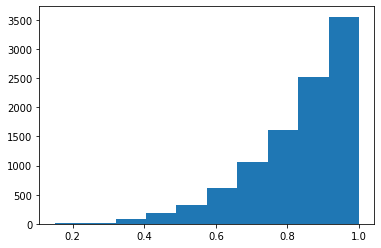

In [11]:
# The beta distribution used here

plt.hist(np.random.beta(5.0, 1.0, 10000))

In [12]:
transf_act

['treatment of municipal solid waste, incineration' (kilogram, SE, None),
 'treatment of sulfidic tailings, from gold mine operation, tailings impoundment' (kilogram, PE, None),
 'gravel and sand quarry operation' (kilogram, RoW, None),
 'wooden board factory construction, organic bonded boards' (unit, RoW, None),
 'polyethylene production, low density, granulate' (kilogram, RoW, None),
 'heat production, mixed logs, at wood heater 6kW' (megajoule, CH, None),
 'land already in use, annual cropland to perennial crop' (kilogram, CI, None),
 'cement production, pozzolana and fly ash 6-14%' (kilogram, BR, None),
 'laser machining, metal, with YAG-laser, 500W power' (hour, RoW, None),
 'oriented strand board production' (cubic meter, RER, None),
 'treatment of waste mineral plaster, collection for final disposal' (kilogram, RoW, None),
 'treatment of inert waste, inert material landfill' (kilogram, CH, None),
 'treatment of residue from mechanical treatment, laptop computer, municipal waste

In [13]:
bw.calculation_setups['multiLCA'] = {'inv': FU, 'ia': [('IPCC 2013', 'climate change', 'GWP 100a')]}
myMultiLCA = bw.MultiLCA('multiLCA')
l_res_base = myMultiLCA.results.reshape(len(FU))

In [23]:
# Simulation: improve the efficiency of transformation activities and calcualte impact of market activities

a, b = 5., 1. # coefficients for beta distribution

l_res_sim = [] # sim = simulation

for x in range(0, 1000):   # twenty iterations, takes some time
    l_res_iter = []

    lca = bw.LCA(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
    lca.lci()
    lca.lcia()
    
    transf_col = [lca.activity_dict[a] for a in transf_act] # get column index of tranformation activities
    
    inds = np.where((np.isin(lca.tech_params["col"],transf_col))
                   &(lca.tech_params["col"]!=lca.tech_params["row"])
                   &(lca.tech_params["amount"]!=0))[0]
    
    vals = lca.tech_params["amount"].copy()
    
    vals[inds] *=  np.random.beta(a, b, len(vals[inds]))
    
    lca.rebuild_technosphere_matrix(vals)
    
    for fu in FU:
        lca.redo_lcia(fu)
        l_res_iter.append(lca.score)
        
    l_res_sim.append(l_res_iter)
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
# Put base and simulation values together in a dataframe

res_df = pd.concat([pd.DataFrame({'Base': l_res_base}, l_names) , 
                    pd.DataFrame(l_res_sim, columns = l_names).T], 
                   axis=1) # use names_list to get names instead
res_df

Base  \
market for manganese sulfate                        8.036235e-01   
market for boric oxide                              2.305038e+00   
market for aluminium sulfate, powder                4.928049e-01   
market for tower silo, plastic                      1.400626e+02   
market for imidazole                                5.101908e+00   
market for impact extrusion of steel, hot, 3 st...  1.056114e+00   
market for succinic acid                            1.049819e+00   
market for dichloromethane                          3.424212e+00   
market for sodium amide                             2.122425e+00   
market for paper, woodcontaining, supercalendered   1.725422e+00   
market for finishing, textile, knit cotton          2.339687e+00   
market for barley grain, feed, organic             -5.037713e-01   
market for limestone, unprocessed                   4.517919e-03   
market for maize grain, feed                        7.023060e-01   
market for tert-butyl amine                         9.076796e+00   
market for cathode, for aluminium electrolysis      3.396663e+00   
market for transport, freight, lorry 16-32 metr...  1.126688e-01   
market for diesel, low-sulfur                       5.636474e-01   
market for barium hydroxide                         4.965070e+00   
market for metal working, average for copper pr...  2.849128e+00   
market for furnace, pellets, 25kW                   2.833305e+03   
market for electricity, low voltage                 1.399811e-01   
market for alkyd paint, white, without water, i...  5.615945e+00   
market for cement, unspecified                      8.274323e-01   
market for selective coat, stainless steel shee...  1.167756e+00   
market for wind turbine, 2.3MW, onshore             1.543096e+06   
market for electricity, high voltage                2.311476e-01   
market for electricity, high voltage                1.483934e-01   
market for harvesting, sugarcane                    2.762861e+02   
market for metal coating facility                   2.198772e+05   
market for electricity, medium voltage              1.658117e-01   
market for 1,1-dimethylcyclopentane                 2.530727e+00   
market for operation, computer, laptop, 68% act...  2.151634e-02   
market for electricity, medium voltage              4.957192e-01   
market for electricity, medium voltage              5.837038e-01   
market for electricity, medium voltage              4.079368e-01   
market for tilapia feed, 24-28% protein             1.653626e+00   
market for carbon monoxide                          1.641205e+00   
market for heat, for reuse in municipal waste i...  1.570709e-01   
market for photovoltaics, electric installation...  7.964434e+03   
market for electricity, low voltage                 5.308633e-01   
market for electricity, low voltage                 5.285914e-01   
market for molasses, from sugar beet                5.398792e-01   
market for 4-tert-butyltoluene                      2.195977e+00   
market for heavy fuel oil, burned in refinery f...  8.376610e-02   
market for zinc coat, pieces, adjustment per mi...  3.140605e-02   
market for impact extrusion of aluminium, 3 str...  1.399738e+00   
market for electricity, high voltage                4.900532e-01   
market for electricity, medium voltage              5.009018e-01   
market for lanthanum oxide                         -3.022249e+01   

                                                                0  \
market for manganese sulfate                             0.571865   
market for boric oxide                                   1.432479   
market for aluminium sulfate, powder                     0.261701   
market for tower silo, plastic                          89.578780   
market for imidazole                                     3.250701   
market for impact extrusion of steel, hot, 3 st...       0.489882   
market for succinic acid                                 1.082536   
market for dichloromethane             

In [25]:
# calculate the ratios between base value and simulation value
res_df_ratio = res_df.div(res_df.Base, axis=0).iloc[:,1:]
res_df_ratio

0         1    \
market for manganese sulfate                        0.711608  0.658662   
market for boric oxide                              0.621456  0.724660   
market for aluminium sulfate, powder                0.531043  0.580270   
market for tower silo, plastic                      0.639562  0.590870   
market for imidazole                                0.637154  0.655338   
market for impact extrusion of steel, hot, 3 st...  0.463853  0.489263   
market for succinic acid                            1.031164  1.471451   
market for dichloromethane                          0.997231  0.997714   
market for sodium amide                             0.401696  0.542409   
market for paper, woodcontaining, supercalendered   0.720911  0.636084   
market for finishing, textile, knit cotton          0.761470  0.823405   
market for barley grain, feed, organic             -0.111903  0.256543   
market for limestone, unprocessed                   0.636725  0.702950   
market for maize grain, feed                        0.560136  0.621534   
market for tert-butyl amine                         0.668114  0.780359   
market for cathode, for aluminium electrolysis      0.610499  0.553048   
market for transport, freight, lorry 16-32 metr...  0.830707  0.815394   
market for diesel, low-sulfur                       0.851522  0.806468   
market for barium hydroxide                         0.494659  0.636150   
market for metal working, average for copper pr...  0.519602  0.510374   
market for furnace, pellets, 25kW                   0.393748  0.377966   
market for electricity, low voltage                 0.612465  0.379790   
market for alkyd paint, white, without water, i...  0.741240  0.620008   
market for cement, unspecified                      0.725707  0.765870   
market for selective coat, stainless steel shee...  0.597692  0.607736   
market for wind turbine, 2.3MW, onshore             0.561190  0.509408   
market for electricity, high voltage                0.874315  0.909577   
market for electricity, high voltage                0.903871  0.897309   
market for harvesting, sugarcane                    0.888515  0.900847   
market for metal coating facility                   0.262609  0.249571   
market for electricity, medium voltage              0.637356  0.914000   
market for 1,1-dimethylcyclopentane                 0.573009  0.692027   
market for operation, computer, laptop, 68% act...  0.505391  0.320697   
market for electricity, medium voltage              0.883790  0.736629   
market for electricity, medium voltage              0.909107  0.785286   
market for electricity, medium voltage              0.752842  0.915672   
market for tilapia feed, 24-28% protein             0.507145  0.724939   
market for carbon monoxide                          0.623928  0.373764   
market for heat, for reuse in municipal waste i...  0.836942  1.056278   
market for photovoltaics, electric installation...  0.556042  0.627770   
market for electricity, low voltage                 0.774242  0.750943   
market for electricity, low voltage                 0.494739  0.556594   
market for molasses, from sugar beet                0.366118  0.565020   
market for 4-tert-butyltoluene                      0.831226  0.762482   
market for heavy fuel oil, burned in refinery f...  0.941124  0.941554   
market for zinc coat, pieces, adjustment per mi...  0.479524  0.614472   
market for impact extrusion of aluminium, 3 str...  0.569621  0.576053   
market for electricity, high voltage                0.971518  0.970755   
market for electricity, medium voltage              0.934296  0.807924   
market for lanthanum oxide                          0.313591  0.464116   

                                                         2         3    \
market for manganese sulfate                        0.675994  0.740264   
market for boric oxide                              0.491957  0.474438   
market for aluminium sulfate, powder                0.661269

In [26]:
# a check
df_base_check = res_df.iloc[:,0].div(res_df.Base, axis=0)
print(df_base_check[df_base_check == 1.0].count(), 'out of' , res_df.shape[0] , 'equals one')
print(df_base_check.isnull().sum(), 'out of' , res_df.shape[0] , 'is NaN')


50 out of 50 equals one
0 out of 50 is NaN


Text(0, 0.5, 'Frequency')

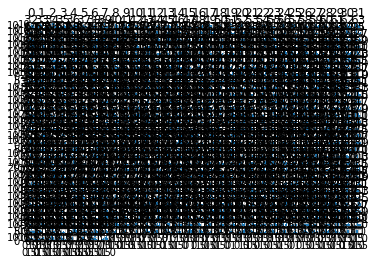

In [27]:
#plot all activities
res_df_ratio.hist()

plt.title('Efficiency ratio of various FUs')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

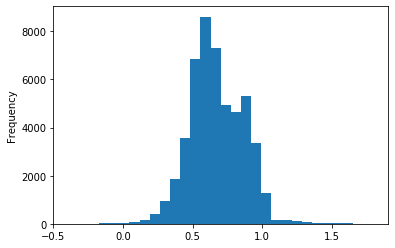

In [28]:
# Plot all values as a single distribution
res_df_ratio.stack().plot.hist(bins = 30)

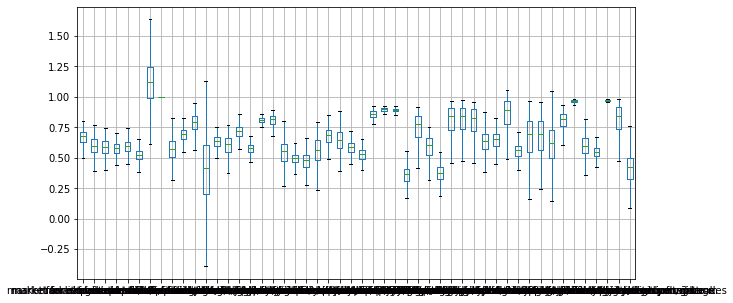

In [29]:
res_df_ratio.T.boxplot(figsize=(10,5), showfliers=False)

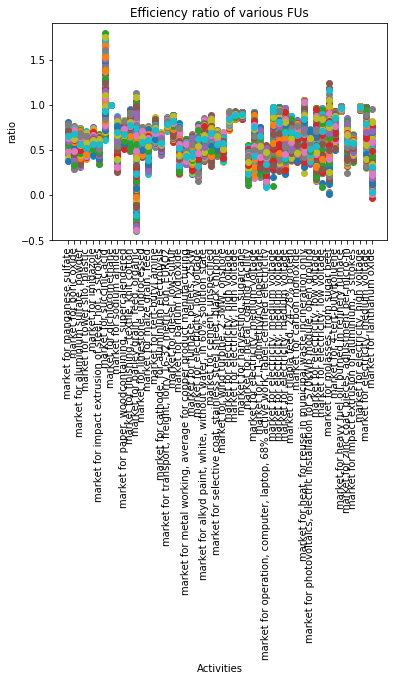

In [30]:
res_df_ratio.plot(kind='line', linestyle = 'none', marker = 'o', legend = None)
plt.title('Efficiency ratio of various FUs')
plt.ylabel('ratio')
plt.xlabel('Activities')
plt.xticks(rotation=90)
plt.xticks(range(0,len(res_df_ratio.index)), res_df_ratio.index, rotation=90)

plt.show()

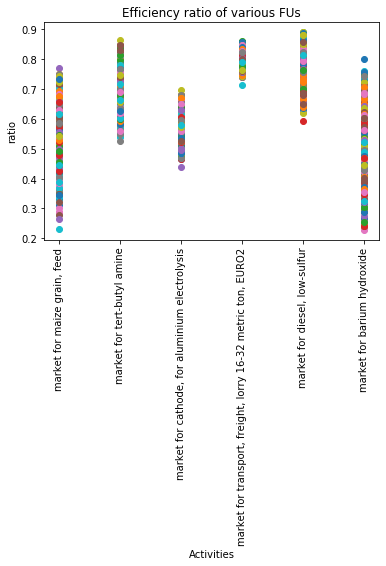

In [31]:
df = res_df_ratio.iloc[13:19,:]

df.plot(kind='line', linestyle = 'none', marker = 'o', legend = None)
plt.title('Efficiency ratio of various FUs')
plt.ylabel('ratio')
plt.xlabel('Activities')
plt.xticks(rotation=90)
plt.xticks(range(0,len(df.index)), df.index, rotation=90)

plt.show()

# Conclusions

We observe two non-linear effects. 

1) In the Part one of this notebook, we see how an artificial but linear efficiency improvement of selected activities results in a non-linear effect on the impact of such activities. Improving the efficiency of coal power plants reduces progressively the impact of e.g. elecricity production, but this effect is not directly proportional to the efficiency gain and is also depending on the activity under analysis, i.e. whether we consider electtricity production or another type of production).

2) in the second part of this notebook, we observe again how a random change of efficiencies for several transformation activities is reflected on the impact of several market activities. This effect is highly dependend on the activity under analysis, and no clear relationship can be identified between the change in efficiency and its effect, i.e. while this effect can be explained for single activities is not generalizable in a straightforward way at database level as each activity will behave differently and might be affected substantially even if the change occurs several step upstream in its life cycle.

Summing up, this means that the effect of upscaling specific activities, under the assumption that this upscaling returns higher efficiency, which is justified by literature, might have an unpredictable and non-linear effect on the impact of a product system and of related product systems. Unig datasets that are built using data from pilot scale activities and are not representative of the potential of such activities at large undustrial scale might thus skew results in unexpected ways.